In some applications, TSMD methods should be insensitive to differences in scale and offset. LoCoMotif does not inherently support this; however, we can achieve this with preprocessing.

In [1]:
import numpy as np

def pointwise_znormalization(ts, w):
    eps = 10e-5
    mean, std = mov_mean_std(ts, w)
    std[std < eps] = eps
    return (ts - mean) / std
    
# inspired by movstd from: Zhong, S., Mueen, A. MASS: distance profile of a query over a time series. Data Min Knowl Disc 38, 1466–1492 (2024). https://doi.org/10.1007/s10618-024-01005-2
def mov_mean_std(T, w):
    if w % 2 == 0:
        w += 1
    
    N = len(ts)
    S   = np.cumsum(np.concatenate(([0], T)))
    S_2 = np.cumsum(np.concatenate(([0], T**2))) ## Bug in paper?
    
    mu    = np.zeros(N)
    sigma = np.zeros(N) 
    
    for i in range(N):
        b = max(0, i - w//2)
        e = min(N, i + w//2 + 1)
        l = e - b
        mu[i] = 1/l * (S[e] - S[b])
        sigma[i] = np.sqrt(1/l * (S_2[e] - S_2[b]) - (1/l * (S[e] - S[b]))**2)
    
    return mu, sigma

### Random walk example
Offset differences occur in benchmark time series with random walk:

(<Figure size 1200x200 with 1 Axes>, [<Axes: >])

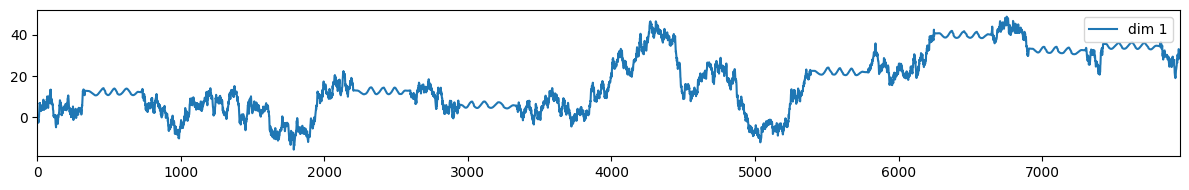

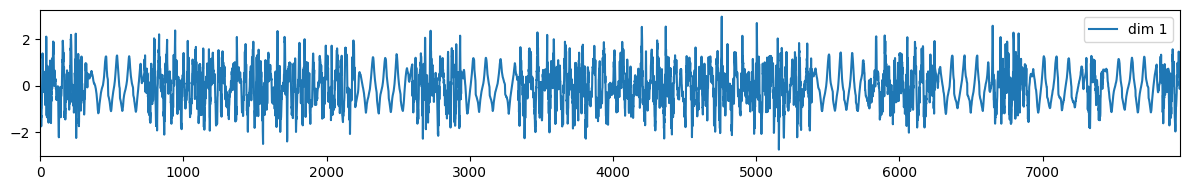

In [2]:
import aeon.datasets as data_loader
import pandas as pd
import locomotif.locomotif as locomotif
import locomotif.visualize as visualize
import tsmd_evaluation.benchmark_generation as gen

np.random.seed(0)
X, y = data_loader.load_classification("Symbols", split=None)
l = 398

# Select a random class
classes = np.unique(y)
c = np.random.choice(classes)

# Select a random number of motifs
k = np.random.randint(2, 8)

X_c = X[y == c, 0, :]

indices = np.random.choice(len(X_c), size=k)
ts_instances = {c: X_c[indices, :]}

ts, gt = gen.generate_benchmark_ts_with_random_walk(20*l, ts_instances, scale=1)
visualize.plot_motif_sets(ts, [])

ts_preprocessed = pointwise_znormalization(ts, w=l//8)
visualize.plot_motif_sets(ts_preprocessed, [])

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Motif Set 1, k: 7'}>],
       dtype=object))

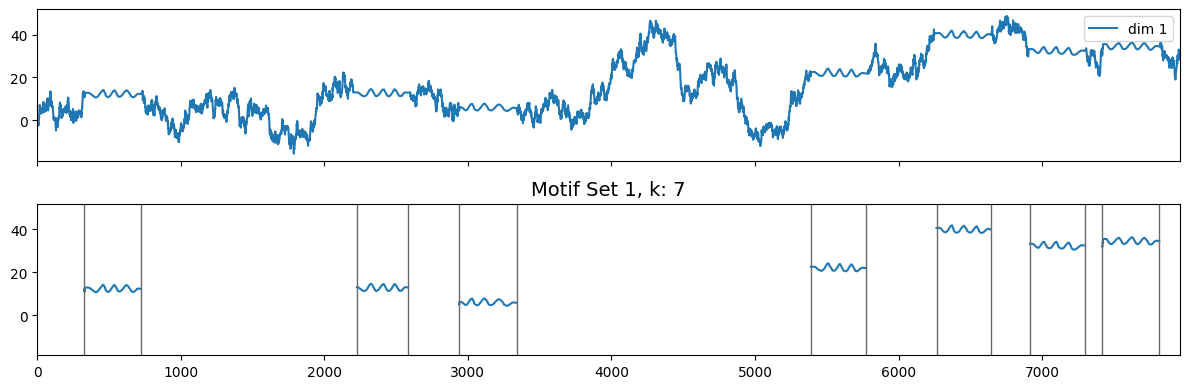

In [3]:
motif_sets = locomotif.apply_locomotif(ts_preprocessed / np.std(ts_preprocessed), l_min=l, l_max=l, rho=0.6)
visualize.plot_motif_sets(ts, motif_sets)

We can also simulate amplitude differences:

(<Figure size 1200x200 with 1 Axes>, [<Axes: >])

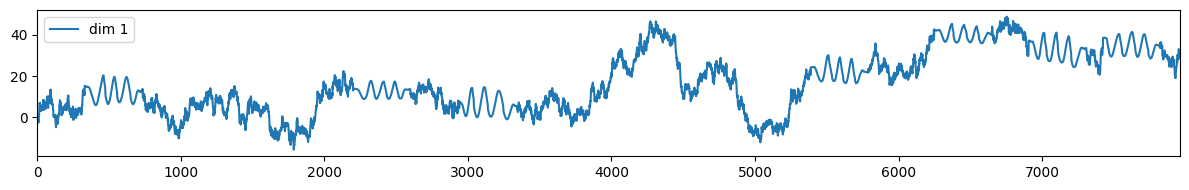

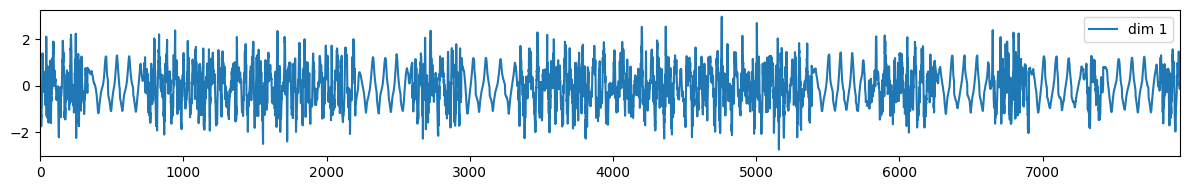

In [4]:
X, y = data_loader.load_classification("Symbols", split=None)
factor = np.random.uniform(1, 5, (1, len(X_c)))
l = 398

np.random.seed(0)

# Select a random class
classes = np.unique(y)
c = np.random.choice(classes)

# Select a random number of motifs
k = np.random.randint(2, 8)

X_c = X[y == c, 0, :]
X_amplitude = X_c * factor.T

indices = np.random.choice(len(X_amplitude), size=k)
ts_instances = {c: X_amplitude[indices, :]}

ts, gt = gen.generate_benchmark_ts_with_random_walk(20*l, {c: X_amplitude[indices, :]}, scale=1)

visualize.plot_motif_sets(ts, [])

ts_preprocessed = pointwise_znormalization(ts, w=l//8)
visualize.plot_motif_sets(ts_preprocessed, [])

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Motif Set 1, k: 6'}>],
       dtype=object))

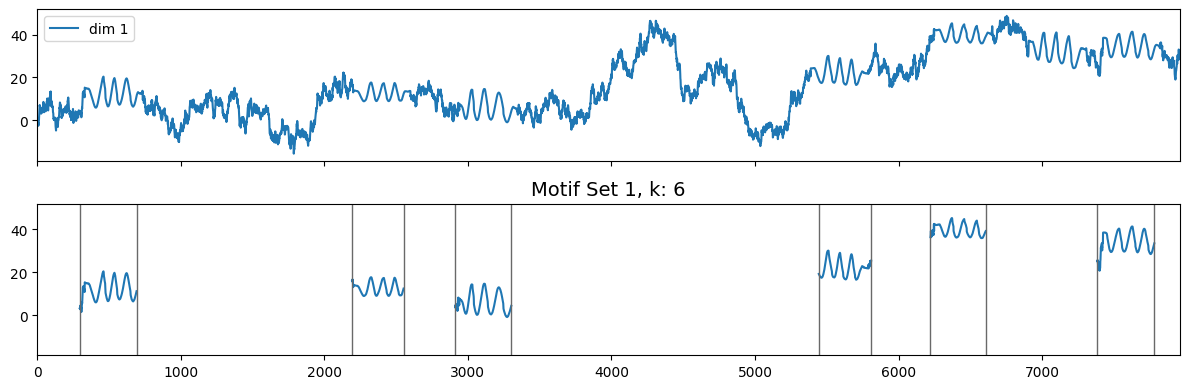

In [5]:
motif_sets = locomotif.apply_locomotif(ts_preprocessed / np.std(ts_preprocessed), l_min=l, l_max=l, rho=0.6)
visualize.plot_motif_sets(ts, motif_sets)

### Electrocardiogram example

Offset differences also occur in real data, e.g., baseline wander in electrocardiogram (ECG) signals, which refers to low-frequency fluctuations that are not of cardiac origin.

In [6]:
# Requires wfdb
import wfdb
record = wfdb.rdrecord('14149', pn_dir='ltdb/1.0.0')
ts = record.p_signal[49630:50500, 0]

(<Figure size 1200x200 with 1 Axes>, [<Axes: >])

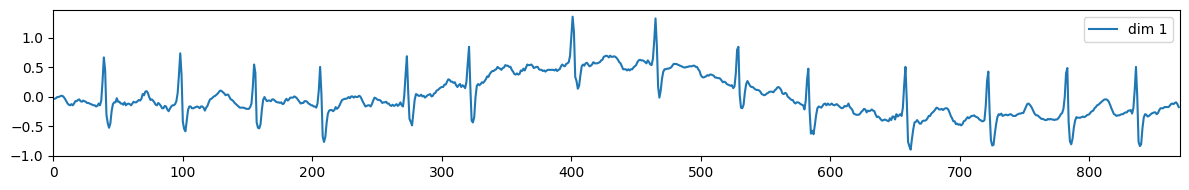

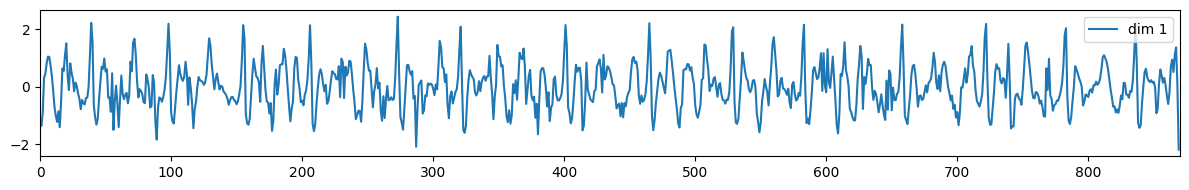

In [7]:
fs = 128

l_min = int(0.6 * fs)
l_max = int(1.0 * fs)

visualize.plot_motif_sets(ts, [])
ts_preprocessed = pointwise_znormalization(ts, w=l_min//6)
visualize.plot_motif_sets(ts_preprocessed, [])

/cw/dtaijupiter/NoCsBack/dtai/daanv/miniconda3/envs/tsmdeval/lib/python3.9/site-packages/locomotif/locomotif.py:95: UserWarning: It is highly recommended to z-normalize the input time series before applying LoCoMotif to it.
  warnings.warn(


(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Motif Set 1, k: 11'}>,
        <Axes: title={'center': 'Motif Set 2, k: 2'}>], dtype=object))

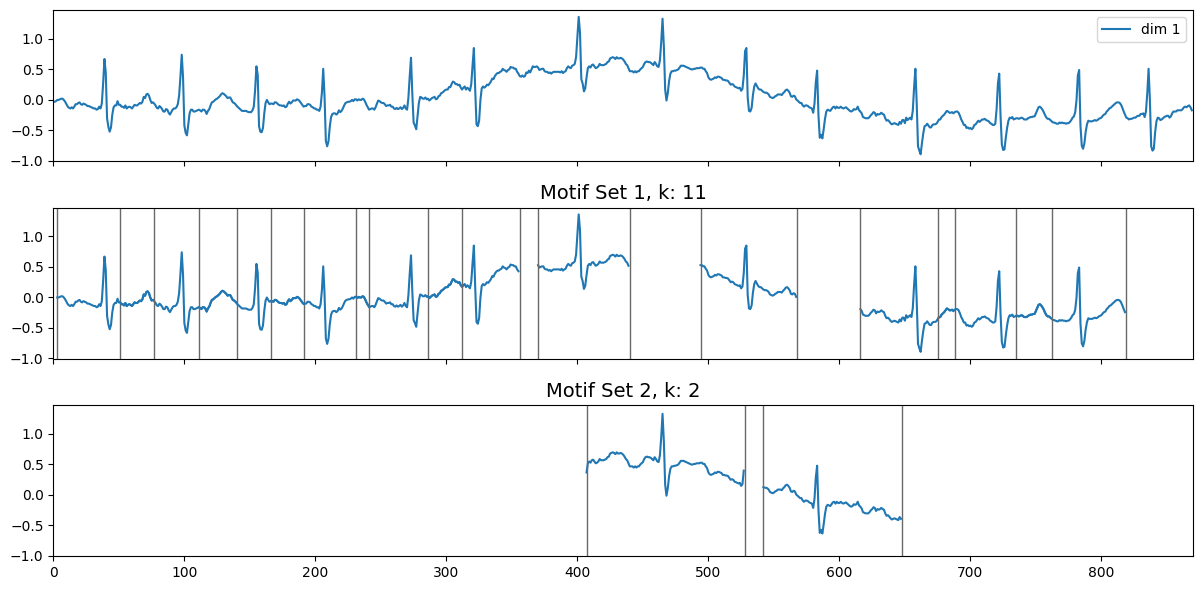

In [8]:
motif_sets = locomotif.apply_locomotif(ts_preprocessed, l_min=l_min, l_max=l_max, rho=0.6, overlap=0.5)
visualize.plot_motif_sets(ts, motif_sets)

In [9]:
# ! pip install numpy==1.24.0
# ! pip install wfdb==4.1.1